### Refereneces
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-3/

### Generating Data

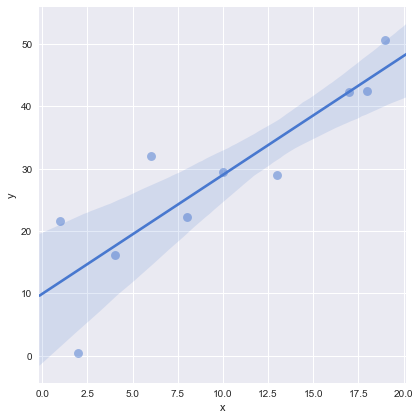

In [119]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

def generate_data(n=10, a=1, b=1, c=0, latent_error_y=10):  
    ''' 
    Create a toy dataset based on a very simple linear model 
    that we might imagine is a noisy physical process

    Model form: y ~ a + bx + cx^2 + e
    '''

    ## create linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(20),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

df = generate_data(a=5, b=2, latent_error_y=10)

g = sns.lmplot(x='x', y='y', data=df, fit_reg=True ,size=6, scatter_kws={'alpha':0.5, 's':80})

plt.show()
## NOTE: `lmplot()` will fit and plot a lin. reg. line by default. 
## Not used here, but can greatly help data exploration in practice.

### Create and fit a Frequentist OLS model


In [120]:
import patsy as pt  
import statsmodels.api as sm

## first, encode model specification as design matrices
fml = 'y ~ 1 + x '  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe',NA_action='raise')

## fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     26.05
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           0.000925
Time:                        12:38:35   Log-Likelihood:                -33.221
No. Observations:                  10   AIC:                             70.44
Df Residuals:                       8   BIC:                             71.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9366      4.359      2.279      0.0

/Users/alhaol/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


# 1. MODEL PARAMETERS

- The statsmodels OLS class computes a menagerie of test statistics, 
- but we're most interested in the estimates for our ββ, expressed as:

- Intercept: μ=−3.04,σ=10.193 
- x: μ=2.00,σ=0.19
- The Frequentist OLS has made a fairly good estimate of x, but the Intercept is quite imprecise under a linear mode

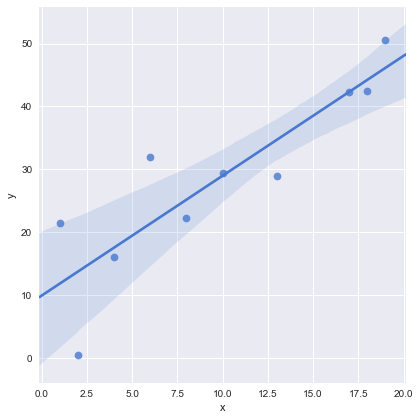

In [121]:
## NOTE: I'll use `seaborn`'s `lmplot` again. 
## This will actually run its own regression, but it uses statsmodels OLS, 
## so while strictly speaking this won't plot exactly the same prediction 
## as the results above, it will be more than close enough for our purposes.

g = sns.lmplot(x='x', y='y', data=df, fit_reg=True,size=6, scatter_kws={'alpha':0.8, 's':60})
plt.show()

### Create and fit a Bayesian OLS model



     
     Here, finally we'll use pymc3 to define a model specification and 
     take samples of ββ from the joint probability distribution and minimise 
     the loss of the log-likelihood evaluated against the posterior predictive distribution. 



In [112]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.GLM.from_formula('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

/Users/alhaol/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -53.763:   8%|▊         | 407/5000 [00:00<00:03, 1408.48it/s]


Optimization terminated successfully.
         Current function value: 53.720442
         Iterations: 11
         Function evaluations: 407


100%|██████████| 2500/2500 [00:06<00:00, 359.11it/s]


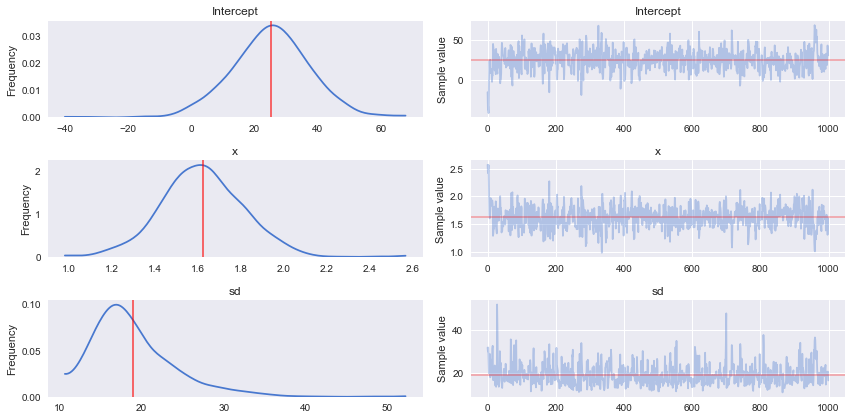

In [122]:
ax = pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),  
    lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()})

plt.show()

### Lets take a look at the parameter values, using a convenience function:



In [87]:
print(pm.df_summary(trc_ols[-1000:]))  



                mean        sd  mc_error    hpd_2.5   hpd_97.5
Intercept   3.995656  6.211535  0.308325  -7.921671  16.031074
x           2.004836  0.011110  0.000538   1.985088   2.027424
sd         30.222562  2.299136  0.072250  26.057903  34.304035


The Bayesian OLS has made very similar estimates of the parameter values as the Frequentist OLS. This is good to see, since both linear models are actually very similar.

Note we now also have an estimate of the Gaussian noise parameter, which is quite close to the true value of 3030.

We also have real intervals a.k.a credible regions (CR) on the estimates of the parameter values. In the Frequentist OLS model the 'confidence intervals' are created by fitting a Normal distribution over the point-estimate MLE values of each parameter. In the Bayesian inferential method, we can simply use the distribution of samples (after convergence) to learn the uncertainty in the parameter values.

### MODEL POSTERIOR PREDICTION

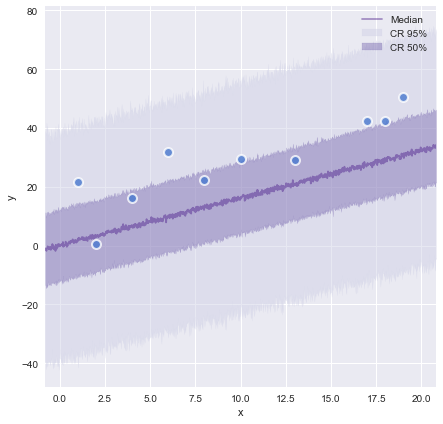

In [123]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10  
                 ,df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)
plt.show()

In the above code, we've used the parameter trace values to generate new predictions ŷ y^ according to the model specification. We've then measured credible regions over that distribution and overplotted a line of fit and credible regions CR (in purple) on the original datapoints. The two credible regions shown are at 50% and 95%, meaning that we expect 50% of the datapoints to fall within the 50% CR and likewise for the 95% CR. You can see by eye that this is about correct.

## Setup¶


In [128]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=dark

In [147]:
import warnings
warnings.filterwarnings('ignore')
from io import StringIO
from collections import OrderedDict
from itertools import combinations

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize
from scipy.stats import norm, laplace, ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.manifold import TSNE
import statsmodels.api as sm

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 

from ipywidgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)
storename = 'data/Emission.csv'

# Local Functions 

In [148]:
def custom_describe(df, nrows=3, nfeats=20):
    ''' Conv fn: concat transposed topN rows, numerical desc & dtypes '''

    print(df.shape)
    rndidx = np.random.randint(0,len(df),nrows)
    dfdesc = df.describe().T

    for col in ['mean','std']:
        dfdesc[col] = dfdesc[col].apply(lambda x: np.round(x,2))
 
    dfout = pd.concat((df.iloc[rndidx].T, dfdesc, df.dtypes),axis=1, join='outer')
    dfout = dfout.loc[df.columns.values]
    dfout.rename(columns={0:'dtype'}, inplace=True)
    
    # add count nonNAN, min, max for string cols
    dfout['count'] = df.shape[0] - df.isnull().sum()
    dfout['min'] = df.min().apply(lambda x: x[:6] if type(x) == str else x)
    dfout['max'] = df.max().apply(lambda x: x[:6] if type(x) == str else x)
    
    return dfout.iloc[:nfeats,:]


def plot_tsne(dftsne, ft_num, ft_endog='is_vw'):
    ''' Convenience fn: scatterplot t-sne rep with cat or cont color'''
   
    pal = 'cubehelix' 
    leg = True

    if ft_endog in ft_num:
        pal = 'BuPu'
        leg = False
    
    g = sns.lmplot('x', 'y', dftsne.sort(ft_endog), hue=ft_endog
           ,palette=pal, fit_reg=False, size=7, legend=leg
           ,scatter_kws={'alpha':0.7,'s':100, 'edgecolor':'w', 'lw':0.4})
    _ = g.axes.flat[0].set_title('t-SNE rep colored by {}'.format(ft_endog))


def trace_median(x):
    return pd.Series(np.median(x,0), name='median')


def plot_traces(trcs, retain=1000, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''
    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
    ax = pm.traceplot(trcs[-retain:], varnames=varnames, figsize=(12,nrows*1.4)
        ,lines={k: v['mean'] for k, v in 
            pm.df_summary(trcs[-retain:],varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs[-retain:], varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')   

In [151]:
df = pd.read_csv('data/Emission.csv',encoding = "ISO-8859-1")


In [152]:
df.columns

Index(['Manufacturer', 'Model', 'Description', 'Transmission',
       'Engine Capacity', 'Fuel Type', 'Electric energy consumption Miles/kWh',
       'wh/km', 'Maximum range (Km)', 'Maximum range (Miles)',
       'Metric Urban (Cold)', 'Metric Extra-Urban', 'Metric Combined',
       'Imperial Urban (Cold)', 'Imperial Extra-Urban', 'Imperial Combined',
       'CO2 g/km', 'Fuel Cost 12000 Miles', 'Electricity cost',
       'Total cost / 12000 miles', 'Euro Standard', 'Noise Level dB(A)',
       'Emissions CO [mg/km]', 'THC Emissions [mg/km]',
       'Emissions NOx [mg/km]', 'THC + NOx Emissions [mg/km]',
       'Particulates [No.] [mg/km]', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')

In [154]:
fts_cat = ['mfr_owner_is_vw','trans','fuel_type','is_tdi']
fts_num = ['metric_combined','metric_extra_urban','metric_urban_cold'
           ,'engine_capacity','emissions_co_mgkm']
ft_endog = ['emissions_nox_mgkm']


In [195]:
df=df[df.columns[:27]]
df1=df[['Transmission','Engine Capacity','Fuel Type','Emissions CO [mg/km]','Particulates [No.] [mg/km]']]
df1=df1.dropna().reset_index(drop=True)

In [197]:
for col in cols:
    print(col)

Transmission
Engine Capacity
Fuel Type
Emissions CO [mg/km]
Particulates [No.] [mg/km]


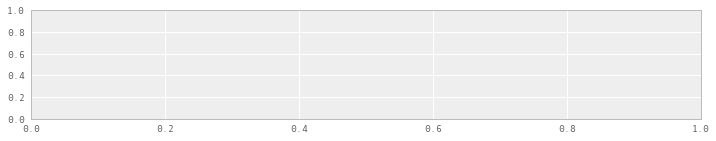

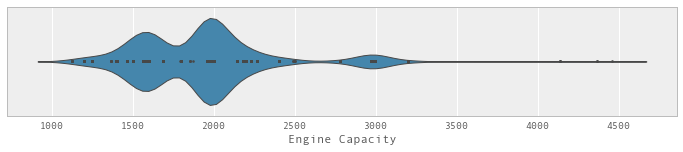

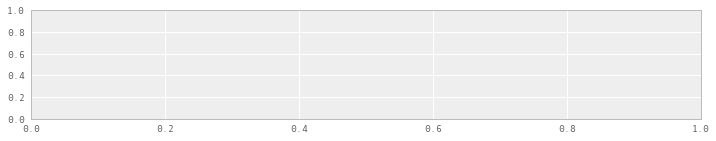

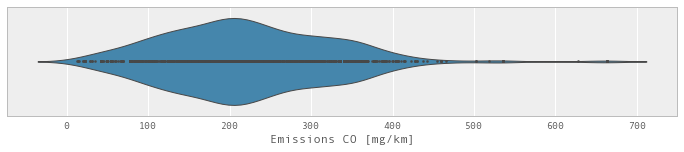

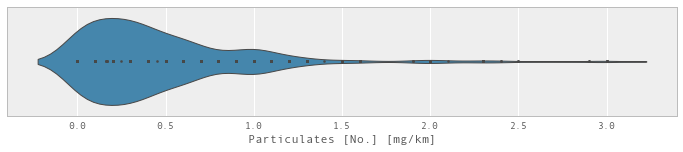

In [210]:
cols=df1.columns.tolist()
for col in cols:
    try:
        f[i], ax1d[i] = plt.subplots(1,1,figsize=(12,2))
        _ = sns.violinplot(x=col, data=df1, ax=ax1d, inner='point')
    except:
        del f, ax1d

In [194]:
## also exclude 3 high-value outliers in the endogenous feat
cols


['Transmission',
 'Engine Capacity',
 'Fuel Type',
 'Emissions CO [mg/km]',
 'Particulates [No.] [mg/km]']

In [178]:
df

,Manufacturer,Model,Description,Transmission,Engine Capacity,Fuel Type,Electric energy consumption Miles/kWh,wh/km,Maximum range (Km),Maximum range (Miles),...,Fuel Cost 12000 Miles,Electricity cost,Total cost / 12000 miles,Euro Standard,Noise Level dB(A),Emissions CO [mg/km],THC Emissions [mg/km],Emissions NOx [mg/km],THC + NOx Emissions [mg/km],Particulates [No.] [mg/km]
0,ALFA ROMEO,Giulietta,1.6 JTDm-2 105 bhp (2014 onwards),M6,1598.0,Diesel,NaN,NaN,NaN,NaN,...,£912,NaN,£912,5,74.0,309.0,NaN,163.0,202.0,0.8
1,ALFA ROMEO,Giulietta,2.0 JTDm-2 150 bhp,M6,1956.0,Diesel,NaN,NaN,NaN,NaN,...,£956,NaN,£956,5,72.1,244.0,NaN,154.0,189.0,0.7
2,ALFA ROMEO,Giulietta,2.0 JTDm-2 175 bhp Alfa TCT,SAT6,1956.0,Diesel,NaN,NaN,NaN,NaN,...,"£1,003",NaN,"£1,003",5,72.0,174.0,NaN,57.0,81.0,0.2
3,ALFA ROMEO,"MiTo, 2012 onwards",1.3 JTDm-2 85 bhp,M5,1248.0,Diesel,NaN,NaN,NaN,NaN,...,£798,NaN,£798,5,73.0,393.0,NaN,167.0,194.0,0.5
4,ALFA ROMEO,"MiTo, 2012 onwards",1.6 JTDm-2 120 bhp,M6,1598.0,Diesel,NaN,NaN,NaN,NaN,...,£980,NaN,£980,5,73.0,389.0,NaN,155.0,216.0,0.3
5,ASTON MARTIN LAGONDA,"DB9, MY2010",Coupé & Convertible March 2010 onwards,M6,5935.0,Petrol,NaN,NaN,NaN,NaN,...,"£3,552",NaN,"£3,552",5,75.0,231.0,32.0,6.0,NaN,NaN
6,ASTON MARTIN LAGONDA,"DB9, MY2010",Coupé & Convertible March 2010 onwards,A6,5935.0,Petrol,NaN,NaN,NaN,NaN,...,"£3,166",NaN,"£3,166",5,73.0,547.0,66.0,9.0,NaN,NaN
7,ASTON MARTIN LAGONDA,"DB9, MY2013 onwards",Coupé & Convertible,A6,5935.0,Petrol,NaN,NaN,NaN,NaN,...,"£3,086",NaN,"£3,086",5,72.0,187.0,41.0,29.0,NaN,NaN
8,ASTON MARTIN LAGONDA,DBS,Coupé & Convertible March 2010 onwards,M6,5935.0,Petrol,NaN,NaN,NaN,NaN,...,"£3,552",NaN,"£3,552",5,75.0,325.0,32.0,12.0,NaN,NaN
9,ASTON MARTIN LAGONDA,DBS,Coupé & Convertible March 2010 onwards,A6,5935.0,Petrol,NaN,NaN,NaN,NaN,...,"£3,357",NaN,"£3,357",5,74.0,577.0,61.0,11.0,NaN,NaN
